# Mid-Course Capstone: Predicting Las Vegas Restaurant Inspections #

## by Lorenz Madarang ##

### Data: https://opendata.lasvegasnevada.gov/Public-Safety/Restaurant-Inspections/q8ye-5kwk ###

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation
from collections import Counter
import operator
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

### Load the Data ###

In [2]:
restaurant=pd.read_csv('Restaurant_Inspections2.csv')

In [3]:
restaurant.tail()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Time,Employee ID,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1
159248,DAYI06QJ2,PR0017255,Subway #35507,Subway #35507,Restaurant,6770 N Durango Dr,Las Vegas,Nevada,89149-4497,8,...,12/22/2016 09:30:00 AM,EE7000860,Re-inspection,0,A,A,'A' Grade,"2910,2930",12/22/2016 09:46:04 AM,"(36.284018, 115.287246)"
159249,DAYI0MOQT,PR0100603,CENTERPLATE CLUB LEVEL RESTAURANT REMOTE SERVI...,CENTERPLATE @ CASHMAN,Caterer,850 N LAS VEGAS,Las Vegas,Nevada,89101,0,...,03/25/2017 11:25:00 AM,EE7001145,Routine Inspection,0,A,A,'A' Grade,NaN,03/25/2017 01:18:42 PM,"(36.1800444, 115.131106)"
159250,DAZZIWEAM,PR0109205,CROMWELL GIADA BAR,"CROMWELL LAS VEGAS, THE",Bar / Tavern,3595 S Las Vegas Blvd,Las Vegas,Nevada,89109-8918,0,...,05/23/2017 01:30:00 PM,EE7001108,Routine Inspection,0,A,A,'A' Grade,2928,05/23/2017 02:10:02 PM,"(36.1150489, 115.1718307)"
159251,DAZZG9K1Z,PR0000007,McDonald's Restaurant 31454,McDonald's Restaurant 31454,Restaurant,10590 Southern Highlands Pkwy,Las Vegas,Nevada,89141-4373,3,...,06/02/2017 09:55:00 AM,EE7001088,Routine Inspection,3,A,A,'A' Grade,"215,2912",06/02/2017 10:38:42 AM,"(35.9972358, 115.2069332)"
159252,DAZZKMVJT,PR0115611,SBS CONCESSION STAND #11,SAM BOYD STADIUM,Snack Bar,7000 RUSSELL,Las Vegas,Nevada,89122,6,...,02/08/2017 06:10:00 PM,EE7001020,Routine Inspection,6,A,A,'A' Grade,"215,2930,2955",02/08/2017 06:43:02 PM,"(36.086048, 115.1793068)"


### Initial Look at the Data ###
By looking at the info of the data, we see that there are some nulls in the data.  The sums of all the null observations shows which columns have the most nulls.  The column "Permit Status" has the most nulls.  

In [4]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159253 entries, 0 to 159252
Data columns (total 23 columns):
Serial Number          159253 non-null object
Permit Number          159253 non-null object
Restaurant Name        159250 non-null object
Location Name          159243 non-null object
Category Name          159253 non-null object
Address                159190 non-null object
City                   159235 non-null object
State                  159253 non-null object
Zip                    159234 non-null object
Current Demerits       159253 non-null int64
Current Grade          159225 non-null object
Date Current           159253 non-null object
Inspection Date        159253 non-null object
Inspection Time        159210 non-null object
Employee ID            159253 non-null object
Inspection Type        159253 non-null object
Inspection Demerits    159253 non-null int64
Inspection Grade       157553 non-null object
Permit Status          39645 non-null object
Inspection Result 

In [5]:
restaurant.isnull().sum()

Serial Number               0
Permit Number               0
Restaurant Name             3
Location Name              10
Category Name               0
Address                    63
City                       18
State                       0
Zip                        19
Current Demerits            0
Current Grade              28
Date Current                0
Inspection Date             0
Inspection Time            43
Employee ID                 0
Inspection Type             0
Inspection Demerits         0
Inspection Grade         1700
Permit Status          119608
Inspection Result           0
Violations              37155
Record Updated              0
Location 1                  0
dtype: int64

### Target Feature Engineering and Converting Inspection Time to Datetime object ###
I created a data model that will predict whether or not a restaurant will get a downgrade in grade after an inspection.  I created a target column that is a boolean column that states or not a restaurant will get a downgrade after an inspection, "1", or not, "0."  To create this target column, I used a regular expression to find whether the word "Downgrade" was present in the "Inspection Result" column.  I also changed the 'Inspection Time' and 'Inspection Date' columns to datetime objects to help with Exploratory Data Analysis by time and by sorting the dataset in chronological order.

In [6]:
#Sample 'Inspection Result' variable
restaurant.loc[45, 'Inspection Result']

"'B' Downgrade"

In [7]:
#Create an empty list that will hold the boolean expression indicating a downgrade
downgrade_cat = []

#Iterate through Dataframe 
for index, row in restaurant.iterrows():
    #Use regex to see if 'Downgrade' is in the 'Inspection Result' column
    #Append downgrade_cat with '1' if present, '0' otherwise
    if re.match('.*(Downgrade)',str(row['Inspection Result'])):
        downgrade_cat.append(1)
    else:
        downgrade_cat.append(0)

#Create new boolean column indicating downgrade or not
restaurant['Downgrade'] = downgrade_cat

In [8]:
#Convert 'Inspection Time' and 'Inspection Date' to datetime object
restaurant["Inspection Time"] = pd.to_datetime(restaurant["Inspection Time"])
restaurant["Inspection Date"] = pd.to_datetime(restaurant["Inspection Date"])

#Create empty list that will hold the year, month, and hour values
year = []
month = []
hour = []

#Iterate through Dataframe
for index, row in restaurant.iterrows():
    year.append(row['Inspection Time'].year)
    month.append(row['Inspection Time'].month)
    hour.append(row['Inspection Time'].hour)
    
restaurant['Year'] = year
restaurant['Month'] = month
restaurant['Hour'] = hour   

In [9]:
#Take a look to make sure that the boolean column matches the "Inspection Result" variable
restaurant.head(n=50)

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Downgrade,Year,Month,Hour
0,DA0BEBWGS,PR0003177,7-Eleven #32224 - SNACK BAR,7-Eleven Convenience Store #32224,Snack Bar,5576 Boulder Hwy,Las Vegas,Nevada,89122-6010,3,...,A,A,'A' Grade,"215,2927",02/09/2017 10:37:14 AM,"(36.101164, 115.0522322)",0,2017.000,2.000,10.000
1,DAZMWKXWQ,PR0000140,Wendy's #4880,Wendy's #4880,Restaurant,1131 W Sunset Rd,Henderson,Nevada,89014-6601,3,...,A,NaN,'A' Grade,211,04/23/2018 03:18:01 PM,"(36.0633057, 115.035572)",0,2018.000,4.000,13.000
2,DAG7WIP7B,PR0000194,Palace Station Trackside Bar,Palace Station,Bar / Tavern,2411 W Sahara Ave,Las Vegas,Nevada,89102-4343,6,...,A,NaN,'A' Grade,"215,2911,2955",05/09/2018 04:44:20 PM,"(36.1442045, 115.1743414)",0,2018.000,5.000,13.000
3,DAQAXU0BQ,PR0000203,Palace Station Palace Pub,Palace Station,Bar / Tavern,2411 W Sahara Ave,Las Vegas,Nevada,89102-4343,8,...,A,NaN,'A' Grade,"202,2955",05/09/2018 04:49:44 PM,"(36.1442045, 115.1743414)",0,2018.000,5.000,15.000
4,DAAVORW0Y,PR0000208,PALACE STATION PIT BAR,Palace Station,Bar / Tavern,2411 W Sahara Ave,Las Vegas,Nevada,89102-4343,6,...,A,NaN,'A' Grade,"211,2930,2955",05/09/2018 04:44:30 PM,"(36.1442045, 115.1743414)",0,2018.000,5.000,14.000
5,DAZYBUAKT,PR0000229,Palace Station Grand Cafe Dishroom,Palace Station,Special Kitchen,2411 W Sahara Ave,Las Vegas,Nevada,89102-4343,0,...,A,NaN,'A' Grade,NaN,05/22/2018 01:26:54 PM,"(36.1442045, 115.1743414)",0,2018.000,5.000,12.000
6,DA1847130,PR0000230,Palace Station Grand Cafe Kitchen,Palace Station,Special Kitchen,2411 W Sahara Ave,Las Vegas,Nevada,89102-4343,6,...,A,NaN,'A' Grade,"211,2908,2929,2930",05/16/2018 11:05:11 AM,"(36.1442045, 115.1743414)",0,2018.000,5.000,13.000
7,DAB2USOGE,PR0000241,Sams Town Bowling Bar,Sams Town,Bar / Tavern,5111 Boulder Hwy,Las Vegas,Nevada,89122-6001,6,...,A,NaN,'A' Grade,"215,2955",04/20/2018 03:22:34 PM,"(36.1128082, 115.0622887)",0,2018.000,4.000,15.000
8,DA00DC1UZ,PR0112115,PIZZA ROCK - COOKLINE / PANTRY,PIZZA ROCK,Special Kitchen,2300 PASEO VERDE Pkwy,Henderson,Nevada,89052,5,...,A,A,'A' Grade,2954,10/06/2017 09:22:08 AM,"(36.0205397, 115.0895425)",0,2017.000,10.000,14.000
9,DA0DZYDFF,PR0022639,Pho Thanh Huong Sandwich,Pho Thanh Huong Sandwich,Restaurant,1131 E Tropicana Ave D,Las Vegas,Nevada,89119-6601,5,...,A,A,'A' Grade,2928,04/13/2017 11:09:20 AM,"(36.100202, 115.13867)",0,2017.000,4.000,10.000


## Exploratory Data Analysis ##
1.) Percentage of Downgrades

2.) Current Demerits Analysis

    a.) Histogram
    b.) t-test
    c.) Linear Regression
    
3.) Downgrades by Restaurant Category

4.) Downgrades by Zip Code

5.) Downgrades by Year, Month, and Hour

************************************************************

#### 1.) Percentage of Downgrades ####
Restaurant downgrades account for about 11% percent of the data.  So it is possible for a model to be about 89% percent accurate by only guessing that a restaurant will not experience a downgrade.  In this instance it is quite important that the focus is on looking at optimizing the sensitivity.

In [10]:
#Create a dataframe that contains only restaurants that have had a downgrade in grade after an inspection
downgrade = restaurant[(restaurant['Downgrade'] == 1)]

#Create a dataframe that contains only restaurants that do not have a downgrade in grade after an inspection
no_downgrade = restaurant[(restaurant['Downgrade'] == 0)]

#Percentage of downgrades
downgrade_percent = (len(downgrade)/len(restaurant)) * 100
print("{:.2F}% of the dataset contains downgrades".format(downgrade_percent))

11.12% of the dataset contains downgrades


#### 2a.) Histogram of Current Demerits ####
Looking at the juxtaposed histograms of the Las Vegas Restaurant population, the non-downgraded restaurants, and the downgraded restaurants, it doesn't look like there is much of a difference in the distribution.  


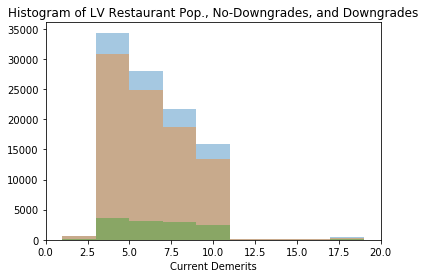

In [11]:
x = restaurant['Current Demerits']
y = no_downgrade['Current Demerits']
z = downgrade['Current Demerits']

#Create juxtaposed histograms 
fig, ax = plt.subplots()
for a in [x, y, z]:
    sns.distplot(a, bins=range(1, 20, 2), ax=ax, kde=False)
ax.set_xlim([0, 20])
ax.set_title("Histogram of LV Restaurant Pop., No-Downgrades, and Downgrades")

#### 2b.) Current Demerits t-test
Looking at the Current Demerit means between the population and the two samples it looks like there is a difference.  To furthur test the differences, I conducted a t-test between the Las Vegas restaurant population current demerit mean and the sampled downgraded restaurant current demerit mean.  The t-test concludes that there is a significant difference between the means.  The 'Current Demerits' column is a very good candiate for a feature in predicting a restaurant's inspection results.  

In [12]:
print('The Mean Current Demerit for the Las Vegas Restaurant population is {:.2F}'.format(restaurant['Current Demerits'].mean()))
print('The Mean Current Demerit for the Non-downgraded restaurants is {:.2F}'.format(no_downgrade['Current Demerits'].mean()))
print('The Mean Current Demerit for the Downgraded restaurants is {:.2F}'.format(downgrade['Current Demerits'].mean()))

The Mean Current Demerit for the Las Vegas Restaurant population is 3.92
The Mean Current Demerit for the Non-downgraded restaurants is 3.79
The Mean Current Demerit for the Downgraded restaurants is 5.00


In [13]:
# t-test between Las Vegas restaurant population and downgraded restaurant sample
from scipy import stats

t2, p2 = stats.ttest_ind(x,z)
print("t-value = " + str(t2))
print("p-value = " + str(2*p2))

t-value = -31.4303057648
p-value = 6.17985462055e-216


#### 2c.) Linear Regression: Current Demerits & Inspection Demerits ####
The number of Inspection Demerits determines whether or not a restaurant will get a downgrade in grade. 

    11-20 Inspection Demerits results in a downgrade to 'B', if it was a 'B' and a reinspection it will drop to a 'C'
    21-40 Inspection Demerits results in a downgrade to 'C', if itw was a 'B' or 'C' and reinspection it will result in closure
    
    41 or more Inspection Demerits will result in closure

Looking at the downgraded restaurant sample it looks like there is a slight positive correlation between the number of current demerits and inspection demerits.  

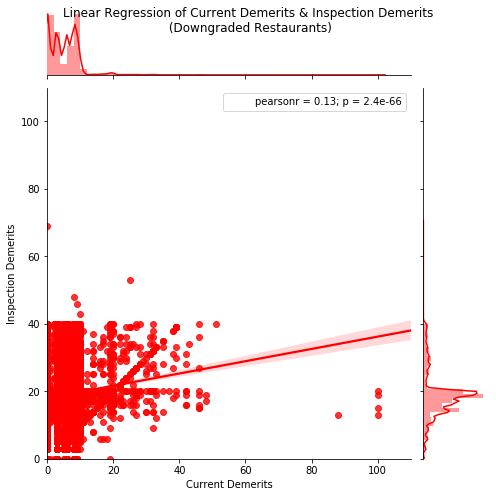

In [14]:
#Scatter plot of Current demerits with Inspection Demerits
ax = sns.jointplot("Current Demerits", "Inspection Demerits", data=downgrade, kind="reg",
                  xlim=(0, 110), ylim=(0, 110), color="r", size=7)

ax.fig.suptitle("Linear Regression of Current Demerits & Inspection Demerits\n (Downgraded Restaurants)")

plt.show()

#### 3.) Downgrades by Category Name ####
For a Restaurant Inspection dataset, it is not very helpful to have a category identified as 'Restaurant.' The majority of the restaurants that have a downgrade are under the 'Restaurant' category.  If we remove the 'Restaurant' category, the next restaurant category with the most downgrades is 'Beer / Tavern'.  

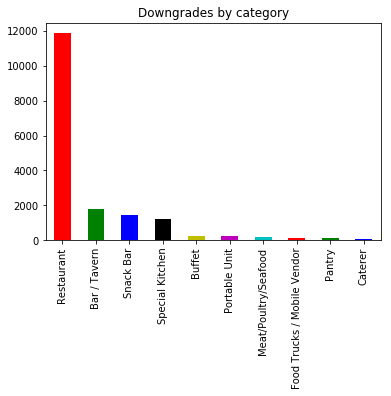

In [15]:
#Get a value count of downgrades by Category and create a pandas series that shows the top 10 categories with downgrades
category_downgrade = downgrade['Category Name'].value_counts()
category_downgrade10 = category_downgrade[:10]

#Create a bar graph of downgrade counts by Restaurant category
my_colors = 'rgbkymc'
category_downgrade10.plot(
                        kind='bar',
                        color=my_colors,
                        title='Downgrades by category')

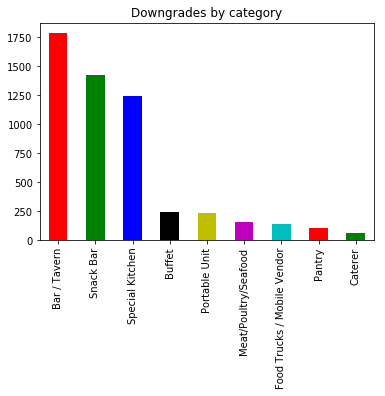

In [16]:
#Remove the 'Restaurant' Category from the dataset 
category_downgrade9 = category_downgrade[1:10]

#Create a bar graph of downgrade counts by Restaurant category
my_colors = 'rgbkymc'
category_downgrade9.plot(
                        kind='bar',
                        color=my_colors,
                        title='Downgrades by category')

### 4.) Downgrades by Zip Code ###
Looking at the graph of the value counts of downgrades for each zip code, the zip code with the highest count of downgrades is 89109.  The zip code 89109 is where the Las Vegas Strip is located.  This zip code is where all the casinos and hotels are located, this zip code is the major draw for Las Vegas tourists.  This graph makes sense as this zip code is densely populated with restaurants.  

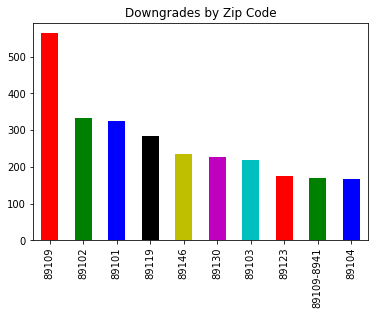

In [17]:
#Get a value count of downgrades by Zip Code and create a pandas series that shows the top 10 zip codes with downgrades
zip_downgrade = downgrade['Zip'].value_counts()
zip_downgrade10 = zip_downgrade[:10]

#Create a bar graph of the downgrade counts by zip code
my_colors = 'rgbkymc'
zip_downgrade10.plot(
                     kind='bar',
                     color=my_colors,
                     title='Downgrades by Zip Code')

### 5.) Downgrades by Year, Month, and Hour ###
The year 2012 has the most downgrades, March has the most downgrades, and 1pm has the most downgrades

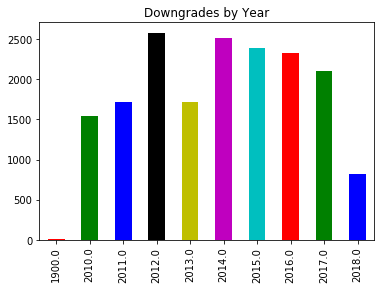

In [18]:
#Get a value count of downgrades by Year and create a pandas series 
year_downgrade = downgrade['Year'].value_counts()
year_downgrade = year_downgrade.sort_index(axis=0, ascending=True)

#Create a bar graph of downgrade counts by Year
my_colors = 'rgbkymc'
year_downgrade.plot(
                    kind='bar',
                    color=my_colors,
                    title='Downgrades by Year')

In [19]:
#Check out the error of restaurants inspected in '1900'
downgrade[(downgrade['Year'] == 1900.0)]

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Downgrade,Year,Month,Hour
63764,DA0899833,PR0098597,Botanas La Lorena,Botanas La Lorena - Rancho Discount Mall,Snack Bar,2901 W Washington Ave T-140,Las Vegas,Nevada,89107,2,...,C,NaN,'C' Downgrade,NaN,02/21/2013 10:26:12 PM,"(36.179855, 115.180194)",1,1900.000,1.000,0.000
80920,DA1024346,PR0015959,TAO TEMPLE MONK BAR,TAO TEMPLE BISTRO @ VENETIAN,Bar / Tavern,3355 S Las Vegas Blvd,Las Vegas,Nevada,89109-8941,0,...,B,NaN,'B' Downgrade,"211,213,214,215,230",02/21/2013 10:26:12 PM,"(36.1226902, 115.1701939)",1,1900.000,1.000,0.000
83120,DA1033935,PR0101112,ACT NIGHTCLUB ANTECHAMBER BAR,ACT NIGHTCLUB @ PALAZZO,Bar / Tavern,3325 S LAS VEGAS Blvd 3400,Las Vegas,Nevada,89109,6,...,B,NaN,'B' Downgrade,"202,215,223,227,230,233",02/21/2013 10:26:12 PM,"(36.1247514, 115.1696661)",1,1900.000,1.000,0.000
95762,DA1097956,PR0023726,HOOKAH PALACE RESTAURANT,HOOKAH PALACE,Restaurant,1030 E Flamingo Rd,Las Vegas,Nevada,89119-7436,0,...,B,NaN,'B' Downgrade,"212,213,215,216,2928,2929,2930,2955",08/26/2013 01:50:29 PM,"(36.1155934, 115.1414363)",1,1900.000,1.000,0.000
95962,DA1098976,PR0023727,HOOKAH PALACE BAR,HOOKAH PALACE,Bar / Tavern,1030 E Flamingo Rd,Las Vegas,Nevada,89119-7436,0,...,B,NaN,'B' Downgrade,"212,215,216,222,2909,2927,2955",08/29/2013 10:41:55 AM,"(36.1155934, 115.1414363)",1,1900.000,1.000,0.000
96959,DA1104267,PR0006059,HARD ROCK BODY ENGLISH SVC BAR 1 - DELETED,HARD ROCK HOTEL & CASINO,Bar / Tavern,4455 S Paradise Rd,Las Vegas,Nevada,89169-6574,0,...,B,NaN,'B' Downgrade,"211,2910,2930,2955",09/18/2013 10:44:18 AM,"(36.1100828, 115.1538714)",1,1900.000,1.000,0.000


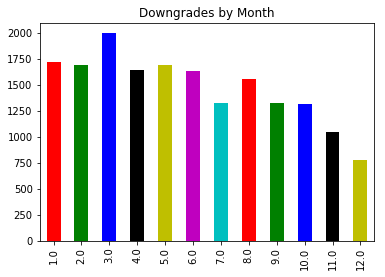

In [20]:
#Get a value count of downgrades by Month and create a pandas series 
month_downgrade = downgrade['Month'].value_counts()
month_downgrade = month_downgrade.sort_index(axis=0, ascending=True)

#Create a bar graph of downgrade counts by Month
my_colors = 'rgbkymc'
month_downgrade.plot(
                    kind='bar',
                    color=my_colors,
                    title='Downgrades by Month')

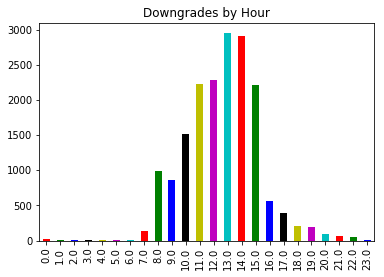

In [21]:
#Get a value count of downgrades by Hour and create a pandas series 
hour_downgrade = downgrade['Hour'].value_counts()
hour_downgrade = hour_downgrade.sort_index(axis=0, ascending=True)

#Create a bar graph of downgrade counts by Hour
my_colors = 'rgbkymc'
hour_downgrade.plot(
                    kind='bar',
                    color=my_colors,
                    title='Downgrades by Hour')

### 2. Feature Engineering: Cumulative Count of Downgrades ###
I created a column that has a cumulative count of downgrades for each restaurant.  The column will show the number of past downgrades that a restaurant has accumulated.  I did this by creating a lambda function that conducts a cumulative sum for each restaurant for every downgrade that occurs.  Looking at the mean cumulative count for resstaurants who do not receive a downgrade after an inspection and the mean cumulative count for restaurants who did receive a downgrade after an inspection it looks like there is a significant difference in the means.

In [22]:
#Sort the restaurant data so that the oldest inspection date is at the top
inspectdate_sort = restaurant.sort_values('Inspection Date', ascending=True)

#Create a Cumulative count column that keeps a count a restaurant's past downgrades
inspectdate_sort["Cum_Count"] = inspectdate_sort.groupby(['Restaurant Name'])['Downgrade'].apply(lambda x: x.cumsum())

In [23]:
#Verify cumulative count worked by looking at a restaurant who has had a lot of downgrades
inspectdate_sort[(inspectdate_sort['Restaurant Name'] == 'Memphis Championship Bar B Que')]

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Downgrade,Year,Month,Hour,Cum_Count
38485,DA0359184,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,"31,32,35,36,37",02/21/2013 10:26:12 PM,"(36.23975, 115.0566759)",0,2010.000,2.000,10.000,0.000
56287,DA0822836,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,'C' Downgrade,"209,211,214,216,217,218,223,225,227,230,232,233",02/21/2013 10:26:12 PM,"(36.23975, 115.0566759)",1,2011.000,6.000,12.000,1.000
58097,DA0840084,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.23975, 115.0566759)",0,2011.000,7.000,11.000,1.000
65789,DA0924504,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,'C' Downgrade,"208,209,213,214,217,218,220,221,228,230,233",02/21/2013 10:26:12 PM,"(36.23975, 115.0566759)",1,2012.000,1.000,13.000,2.000
66007,DA0926680,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.23975, 115.0566759)",0,2012.000,1.000,14.000,2.000
89528,DA1066228,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,202,04/25/2013 03:44:31 PM,"(36.23975, 115.0566759)",0,2013.000,4.000,11.000,2.000
100517,DA1121361,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,"2928,2930",11/26/2013 09:41:14 AM,"(36.23975, 115.0566759)",0,2013.000,11.000,10.000,2.000
111965,DA1170383,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,"215,216,2928,2930,2955",06/13/2014 12:41:51 PM,"(36.23975, 115.0566759)",0,2014.000,6.000,13.000,2.000
127165,DA1494582,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,'B' Downgrade,"207,215,216,218,2912,2928,2930,2955",04/14/2015 09:32:37 AM,"(36.23975, 115.0566759)",1,2015.000,4.000,11.000,3.000
127930,DA1500445,PR0008406,Memphis Championship Bar B Que,Memphis Championship Bar B Que,Restaurant,4379 N Las Vegas Blvd,Las Vegas,Nevada,89115-0640,0,...,NaN,Compliant,"2909,2925",04/28/2015 03:26:00 PM,"(36.23975, 115.0566759)",0,2015.000,4.000,10.000,3.000


In [24]:
#Create datasets with restaurants who did not receive a downgrade and restaurants who did receive a downgrade

no_downgradesort = inspectdate_sort[(inspectdate_sort['Downgrade']==0)]
downgradesort = inspectdate_sort[(inspectdate_sort['Downgrade']==1)]

In [25]:
no_downgradesort['Cum_Count'].mean()

0.9692756571929155

In [26]:
downgradesort['Cum_Count'].mean()

3.089486469690978

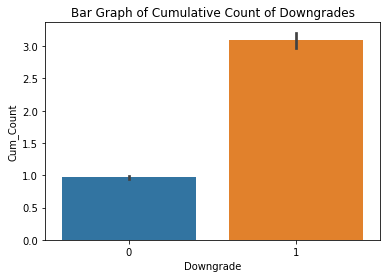

In [27]:
#Mean Bar graph of Cumulative Counts by Downgrade category
sns.barplot(x="Downgrade", y="Cum_Count", data=inspectdate_sort)
plt.title('Bar Graph of Cumulative Count of Downgrades')

### Gradient Boosting Model ###
I used a Gradient Boosting model to predict a downgrade after an inspection.  There are quite a bit of null values in the data so, I created a dataframe that does not have any nulls in cumulative counts column.  After that I created a feature dataset that includes:

    1. Category Name
    2. City
    3. Zip Code
    4. Current Demerits
    5. Current Grade
    6. Inspection Type
    7. Cumulative Count
 
 Some of the variables are categorical variables, so I converted those variables into integer values by using the get dummies pandas method.  

In [28]:
#Create dataframe does not have any null values for "Cum_Count"
inspectdate_sort = inspectdate_sort[pd.notnull(inspectdate_sort['Cum_Count'])]

#Reset the index
inspectdate_sort = inspectdate_sort.reset_index()

In [29]:
#Look at info to ensure that the number of non-null values match across the feature columns
inspectdate_sort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159250 entries, 0 to 159249
Data columns (total 29 columns):
index                  159250 non-null int64
Serial Number          159250 non-null object
Permit Number          159250 non-null object
Restaurant Name        159250 non-null object
Location Name          159240 non-null object
Category Name          159250 non-null object
Address                159187 non-null object
City                   159232 non-null object
State                  159250 non-null object
Zip                    159231 non-null object
Current Demerits       159250 non-null int64
Current Grade          159222 non-null object
Date Current           159250 non-null object
Inspection Date        159250 non-null datetime64[ns]
Inspection Time        159207 non-null datetime64[ns]
Employee ID            159250 non-null object
Inspection Type        159250 non-null object
Inspection Demerits    159250 non-null int64
Inspection Grade       157550 non-null object
Pe

In [35]:
inspectdate_sort['Year'] = inspectdate_sort['Year'].astype('category')
inspectdate_sort['Month'] = inspectdate_sort['Month'].astype('category')
inspectdate_sort['Hour'] = inspectdate_sort['Hour'].astype('category')

In [30]:
#Create feature dataset 
X = inspectdate_sort[['Category Name', 'City', 'Zip', 'Current Demerits', 'Current Grade', 'Inspection Type', 'Cum_Count' ]]

#Get numerical values for the categorical variables
X = pd.get_dummies(X)

In [31]:
#Confirm get_dummies method worked correctly
X.head()

,Current Demerits,Cum_Count,Category Name_Bakery Sales,Category Name_Banquet Kitchen,Category Name_Banquet Support,Category Name_Bar / Tavern,Category Name_Barbeque,Category Name_Beer Bar,Category Name_Buffet,Category Name_Caterer,...,Current Grade_A,Current Grade_B,Current Grade_C,Current Grade_N,Current Grade_O,Current Grade_X,Inspection Type_Epidemiological Investigation,Inspection Type_Re-inspection,Inspection Type_Routine Inspection,Inspection Type_Survey
0,3,0.000,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,3,0.000,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1.000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,9,1.000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,8,0.000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [32]:
#Create Target column
Y = inspectdate_sort['Downgrade']

from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [33]:
X_train.shape 

(127400, 3624)

In [34]:
from sklearn.feature_selection import SelectKBest

sel = SelectKBest()

sel.fit(X_train, y_train)

/Users/lorenzmadarang/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  47  157  214  284  301  430  553  696  787 1025 1034 1086 1441 1564 1590
 1702 1812 1817 2048 2124 2261 2425 2523 2524 2655 2856 3287 3557 3611] are constant.
  UserWarning)
/Users/lorenzmadarang/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=10, score_func=<function f_classif at 0x114136400>)

In [35]:
sel.transform(X_train).shape

(127400, 10)

In [36]:
#Apply Feature Selection on the train and test data

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

#### Gradient Boost Model with Default Settings ####
First I ran a Gradient Boost Model with the default settings. Gradient Boost model with the default settings was not the best.  My main measure of success for the model is the sensitivity.  The sensitivity for the Gradient Boost model is only about 57% only a little better than a coin flip.  

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

#Sensitivity and Specificity Score on the test dataset
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.5733333333333334
Specificity is 0.8929944400317712


#### Gradient Boost Model with Gridsearch ####
Lets see if we can improve the model by iterating through various model parameters via Gridsearch.  With Gridsearch, I set the scoring to 'precision' because sensitivity was my main measure of success for the model.  The set of parameters I used for GridSearch were:

    1. n_estimators: [100, 200, 500, 700, 1000]
    2. max_depth: [2, 3, 5, 7, 9, 15]
    3. loss: ['deviance', 'exponential']

The parameters that provided the best precision for the Gradient Boost model were:
    
    1. n_estimators: 100
    2. max_depth: 2
    3. loss: 'exponential'

In [38]:
parameters = [{'n_estimators': [100, 200, 500, 700, 1000], 'max_depth': [2, 3, 5, 7, 9, 15], 'loss': ['deviance', 'exponential']}]

#Instantiating and fitting model through grid search
grid_clf = GridSearchCV(clf, param_grid=parameters, scoring='precision')
grid_clf.fit(X_train, y_train)

#Printing the best score from the model
print('Best Score:', grid_clf.best_score_)

#Saving and printing the best parameters from the model
best_params = grid_clf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.617813242806
Best Parameters: {'loss': 'exponential', 'max_depth': 2, 'n_estimators': 100}


In [60]:
best_clf = ensemble.GradientBoostingClassifier(**best_params)

best_clf.fit(X_train, y_train)

predict_train = best_clf.predict(X_train)
predict_test = best_clf.predict(X_test)

#Sensitivity and Specificity Score on the test dataset with the Best GB GridSearch paramters
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.6410256410256411
Specificity is 0.8901053827222818


In [40]:
#Cross-validation Score on the test and train dataset from Best GB GridSearch parameters
from sklearn.model_selection import cross_val_score
scores_GBtest = cross_val_score(best_clf, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_GBtest.mean(), 
                                                                               scores_GBtest.std()*2))
scores_GBtrain = cross_val_score(best_clf, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores - Train Set: {:.5f}(+/- {:.2f})'.format(scores_GBtrain.mean(), 
                                                                               scores_GBtrain.std()*2))

Cross Validation Accuracy Scores - Test Set: 0.88848(+/- 0.00)
Cross Validation Accuracy Scores - Train Set: 0.89035(+/- 0.00)


#### Gradient Boost Model Variable Importance ####
The top three variables for the Gradient Boost Model are:

    1. Cumulative Count of Downgrades
    2. Current Restaurant Demerits
    3. Whether or not the Restaurant was in the 'Caterer' category

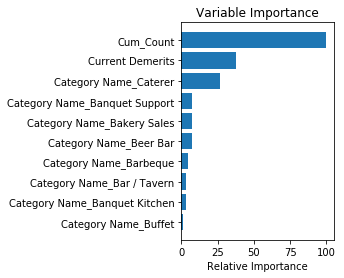

In [41]:
feature_importance = best_clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Random Forest  Model ###
I used a Random Forest model for the data.  I used the same training and test data.  I used a Random Forest model with default settings and I used a GridSearch optimized Random Forest model.  The Random Forest model with the default settings is only a little bit better than a coin flip with a sensitivity score of 51%.  

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

predict_test = rfc.predict(X_test)

#Sensitivity and Specificity Score on the test dataset
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.5136518771331058
Specificity is 0.8950230296827022


#### Random Forest Model with Gridsearch ####
With GridSearch I optimized the Random Forest model by finding the highest precision score.  Also, I used these parameters to find the best Random Forest Model:

        1. n_estimators:[10,100,500]
        2. max_features:['auto', 'sqrt', 'log2']
        3. min_samples_split:[2,8,20]
        4. bootstrap:[True, False]
        5. max_depth:[5,6,7,8]

The Random Forest model that had the higest precision score had these parameters:

        1. n_estimators: 100
        2. max_features: 'auto'
        3. min_samples_split: 2
        4. bootstrap: False
        5. max_depth: 6

In [43]:
# Set of parameters to serach through for best score in Grid Search CV
parameters = {'n_estimators':[10,100,500],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False],
             'max_depth':[5,6,7,8]}

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(rfc, param_grid=parameters, scoring='precision', cv=5)
grid_rfc.fit(X_train, y_train)
print('Best Score:', grid_rfc.best_score_)
best_params_rfc = grid_rfc.best_params_
print('Best Parameters:', best_params_rfc)

Best Score: 0.647582325274
Best Parameters: {'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}


In [53]:
best_rfc = RandomForestClassifier(**best_params_rfc)

best_rfc.fit(X_train, y_train)

predict_train = best_rfc.predict(X_train)
predict_test = best_rfc.predict(X_test)

#Sensitivity and Specificity Score on the test dataset
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.6762589928057554
Specificity is 0.8899750875090663


In [54]:
matrix

array([[28222,    45],
       [ 3489,    94]])

In [55]:
len(X_test)

31850

In [59]:
# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_rfctrain = cross_val_score(best_rfc, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_rfctrain.mean(), 
                                                                      (scores_rfctrain.std()*2)))
scores_rfctest = cross_val_score(best_rfc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_rfctest.mean(), 
                                                                                 scores_rfctest.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.891(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.889(+/- 0.00)


### Support Vector Machine Model ###
I ran a Support Vector Machine Model on default settings and then I ran a Support Vector Machine Model with specific settings for the 'gamma' and 'C' parameters.  The parameter values I found were from the best parameters for a Support Vector Model for the Iris dataset.  I tried running gridsearch on a Support Vector Machine model but it took too long to run.  Specifying the parameters 'gamma' and 'C' did not improve the model.

In [46]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train,y_train)

predict_test = svc.predict(X_test)
#Sensitivity and Specificity Score on the test dataset
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.5360501567398119
Specificity is 0.891789033015128


In [48]:
svc = SVC(random_state=42, C=1.0, gamma=0.1)
svc.fit(X_train,y_train)

predict_test = svc.predict(X_test)
#Sensitivity and Specificity Score on the test dataset
matrix = confusion_matrix(y_test, predict_test)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.5360501567398119
Specificity is 0.891789033015128


In [49]:
# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_svctrain = cross_val_score(svc, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_svctrain.mean(), 
                                                                      (scores_svctrain.std()*2)))
scores_svctest = cross_val_score(svc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svctest.mean(), 
                                                                                 scores_svctest.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.891(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.888(+/- 0.00)


### Model Analysis ###
Of the three models I ran and the parameters I used let's see which one had the best accuracy.  

In [50]:
score_list = [['Gradient_Boost', scores_GBtrain.mean(), scores_GBtest.mean()],
             ['Random_Forest', scores_rfctrain.mean(), scores_rfctest.mean()],
             ['Support_Vector', scores_svctrain.mean(), scores_svctest.mean()]]
scores_overall = pd.DataFrame(score_list, columns=['Model','Mean_Accuracy_Training','Mean_Accuracy_Test'])
scores_overall.sort_values('Mean_Accuracy_Test', ascending=False)

,Model,Mean_Accuracy_Training,Mean_Accuracy_Test
1,Random_Forest,0.890,0.889
0,Gradient_Boost,0.890,0.888
2,Support_Vector,0.891,0.888


## Conclusion ##
For this capstone project, I wanted to build models that were able to predict if a restaurant in my hometown of Las Vegas was going to receive a downgrade in grade after an inspection.  I was able to engineer features from the open dataset from the Las Vegas City government website.  I created a target feature by using a regex algorithm to find the word 'Downgrade' in the 'Inspection Result' column.  I converted the 'Inspection Date' and 'Inspection Time' columns into a datetime object.  Finally, I created a cumulative count of downgrades for each restaurant.  I created a set of input features, converted the categorical features into integer features, and then finally conducted a KBest feature selection process that only yielded the top ten features.  With these top ten features I ran three data models.  

Overall, the model that most accurately predicted the instance of a downgraded was a Random Forest classifier. The best Random Forest Classifier was found by iterating through a list of parameters using GridSearch.  The GridSearch was looking for the highest precision score.  With the optimized Random Forest Classifier, the data model was able to predict a correct downgrade in grade after an inspection 67% of the time.  

A practical use of the model would be a machine learning optimized decision to inspect restaurant.  When restaurant inspectors inspect restaurants through random choice, 1 out of 10 out of the restaurants will result in a downgrade.  If a restaurant inspector used a Random Forest classifier-optimized search, about 7 out of 10 restaurants would result in a downgrade.  That's 6 more restaurants than by random choice and 6 more restaurants that would be corrected for health code violations.  I believe this would help prevent foodborne illnesses more effectively as restaurant inspectors would be inspecting more restaurants who are most at risk of getting a downgrade.